In [1]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
from matplotlib import cm

The 1D Allen-Cahn equation is given by

$$
\frac{\partial u}{\partial t} = \epsilon \frac{\partial^2 u}{\partial x^2} + u - u^3
$$

We solve for $x \in [-1,1], t \in [0, 70],$ with $\epsilon=0.01,$ subject to Dirichlet boundary conditions

$$
u(-1,t) = -1 \\
u(1,t) = 1
$$

and the initial condition

$$
u(x,0) = 0.53x + 0.47 \sin(-1.5\pi x) 
$$

In [2]:
# Code adapted from: https://ora.ox.ac.uk/objects/uuid:223cd334-15cb-4436-8b77-d30408f684c5/download_file?safe_filename=NA-03-14.pdf&file_format=application%2Fpdf&type_of_work=Report

def etdrk_allen_cahn(nx, nt):

    def cheb(nx):
        if nx == 0:
            return (0, 1)
        x = np.cos(np.pi*np.arange(0, nx+1)/nx)
        c = -1*(np.array((nx-1)*[1]))
        c = np.array([2]+[c_i**2 if i%2==1 else c_i for i, c_i in enumerate(c)]+[2]).reshape(-1,1)
        XT = np.tile(x,(nx+1,1))
        X = XT.T
        dX = X-XT
        D = (c*(1/c).T) / (dX+np.eye(nx+1))
        D = D - np.diag(np.sum(D.T, axis=0))
        return (D, x.reshape(-1,1))

    D, x = cheb(nx)
    x = x[1:nx]
    w = 0.53*x + 0.47*np.sin(-1.5*np.pi*x) - x
    u = w+x
    u = np.insert(u,0,1)
    u = np.append(u,-1).reshape(-1,1)

    h = 0.25
    M = 32
    r = 15*np.exp(1j*np.pi*(np.arange(1,M+1)-0.5)/M)
    L = np.matmul(D,D)
    L = 0.01*L[1:nx,1:nx]
    A = h*L
    E = sp.expm(A)
    E2 = sp.expm(A/2)
    I = np.eye(nx-1)
    Z = np.zeros((nx-1, nx-1))
    f1 = Z
    f2 = Z
    f3 = Z
    Q = Z

    for j in range(1, M+1):
        z = r[j-1]
        zIA = sp.inv(z*I-A)
        Q = Q + h*zIA*(np.exp(z/2)-1)
        f1 = f1 + h*zIA*(-4-z+np.exp(z)*(4-3*z+(z**2)))/(z**2)
        f2 = f2 + h*zIA*(2+z+np.exp(z)*(z-2))/(z**2)
        f3 = f3 + h*zIA*(-4-3*z-(z**2)+np.exp(z)*(4-z))/(z**2)
        
    f1 = np.real(f1/M)
    f2 = np.real(f2/M)
    f3 = np.real(f3/M)
    Q = np.real(Q/M)

    uu = u
    tt = [0]
    tmax = nt
    nmax = int(np.round(tmax/h))
    nplt = int(np.floor((tmax/nt)/h))

    for n in range(1, nmax+1):
        t = n*h
        Nu = (w+x) - (w+x)**3
        a = E2@w + Q@Nu
        Na = a + x - (a+x)**3
        b = E2@w + Q@Na
        Nb = b + x - (b+x)**3
        c = E2@a + Q@(2*Nb-Nu)
        Nc = c + x - (c+x)**3
        w = E@w + f1@Nu + 2*f2@(Na+Nb) + f3@Nc
        if n % nplt == 0:
            u = w+x
            u = np.insert(u,0,1)
            u = np.append(u,-1).reshape(-1,1)
            uu = np.append(uu, u, axis=1)
            tt.append(t)
    tt = np.array(tt)
    x = np.insert(x.flatten(),0,1)
    x = np.append(x, -1)

    return x, tt, uu

In [3]:
x, tt, uu = etdrk_allen_cahn(100, 70)

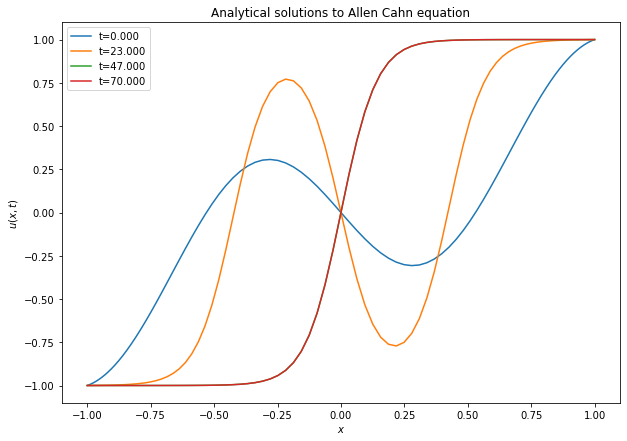

In [4]:
fig, ax = plt.subplots(figsize=(10,7))
t_idx = [0, int(71/3), int(2*71/3), 71-1]
for t_id in t_idx:
    sol = uu.T[t_id]
    t_i = tt[t_id]
    ax.plot(x, sol, label=f"t={t_i:.3f}")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x,t)$")
    ax.set_title("Analytical solutions to Allen Cahn equation")
ax.legend()
plt.show()

In [5]:
print(x.shape, tt.shape)

(101,) (71,)


(71, 101) (71, 101) (71, 101)


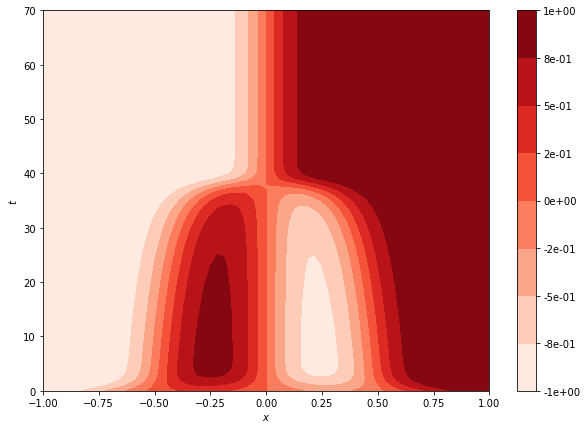

In [6]:
fig, ax = plt.subplots(figsize=(10,7))
x_grid, t_grid = np.meshgrid(x, tt)
cf = ax.contourf(x_grid, t_grid, uu.T, cmap="Reds")
print(x_grid.shape, t_grid.shape, uu.T.shape)
cb = fig.colorbar(cf, format='%.0e', ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
plt.show()

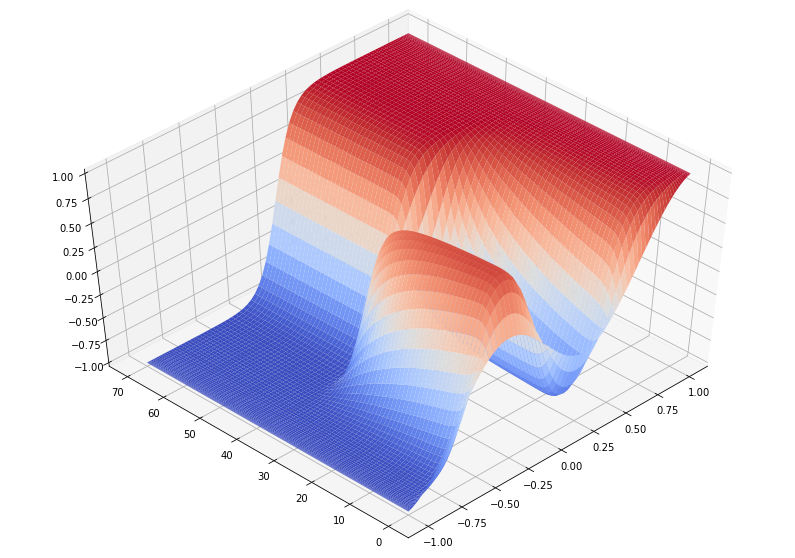

In [7]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(x_grid, t_grid, uu.T, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.view_init(elev=50, azim=-135)
plt.show()

A simpler solution can be obtained with Dirichlet boundary conditions

$$
u(0,t) = 0 \\
u(2\pi,t) = 0
$$

and the initial condition

$$
u(x,0) = 0.25 \sin(x) 
$$

In [2]:
def fft_allen_cahn(x, t, epsilon):
    
    nx, nt = len(x), len(t)
    dt=0.001
    v=0.25*np.sin(x)
    k = np.arange(0,nx/2)
    k = np.append(k, 0)
    k = np.concatenate((k, np.arange(-nx/2+1,0)))
    k = k*1j
    k2=np.real(np.square(k))
    tmax=np.max(t)
    tplot=tmax/(nt-1)
    plotgap=int(np.round(tplot/dt))
    nplots=int(np.round(tmax/tplot))
    data = np.zeros((nplots+1,nx))
    data[0,:] = v

    for i in np.arange(1,nplots+1):
        for n in np.arange(1,plotgap+1):
            v_hat = np.fft.fft(v) # converts to Fourier space
            vv = np.power(v, 3) # computes nonlinear term in real space
            vv = np.fft.fft(vv) # converts nonlinear term to Fourier space
            v_hat = np.divide(v_hat*(1/dt+1)-vv, 1/dt-k2*epsilon) # Implicit / Explicit
            v = np.fft.ifft(v_hat)
        data[i,:] = np.real(v)
    
    return data

In [31]:
xgrid = np.linspace(0, 2*np.pi, 8000)
tgrid = np.linspace(0, 5, 26)
data = fft_allen_cahn(xgrid, tgrid, epsilon=0.001)

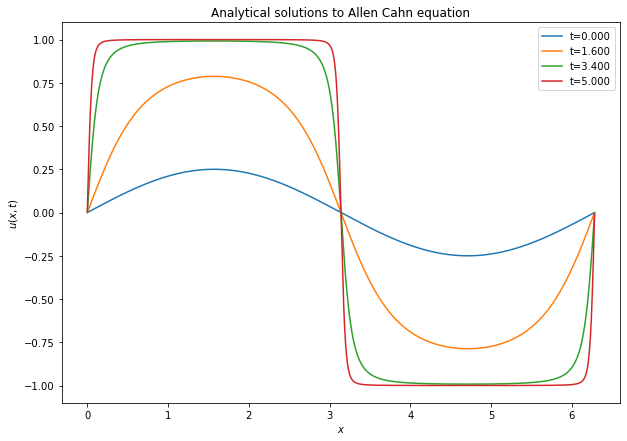

In [32]:
fig, ax = plt.subplots(figsize=(10,7))
t_idx = [0, int(26/3), int(2*26/3), 26-1]
for t_id in t_idx:
    sol = data[t_id]
    t_i = tgrid[t_id]
    ax.plot(xgrid, sol, label=f"t={t_i:.3f}")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x,t)$")
    ax.set_title("Analytical solutions to Allen Cahn equation")
ax.legend()
plt.show()

(26, 8000) (26, 8000) (26, 8000)


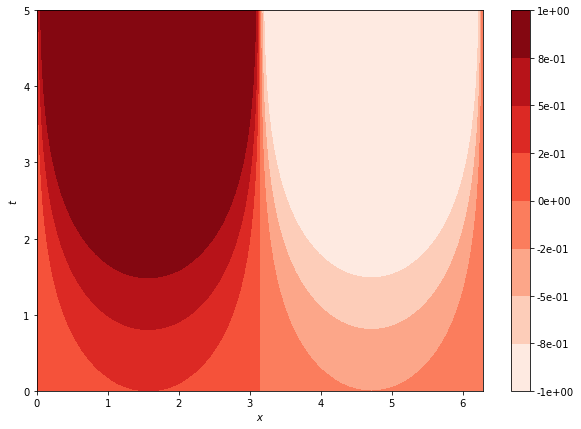

In [33]:
fig, ax = plt.subplots(figsize=(10,7))
x_grid, t_grid = np.meshgrid(xgrid, tgrid)
cf = ax.contourf(x_grid, t_grid, data, cmap="Reds")
print(x_grid.shape, t_grid.shape, data.shape)
cb = fig.colorbar(cf, format='%.0e', ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
plt.show()

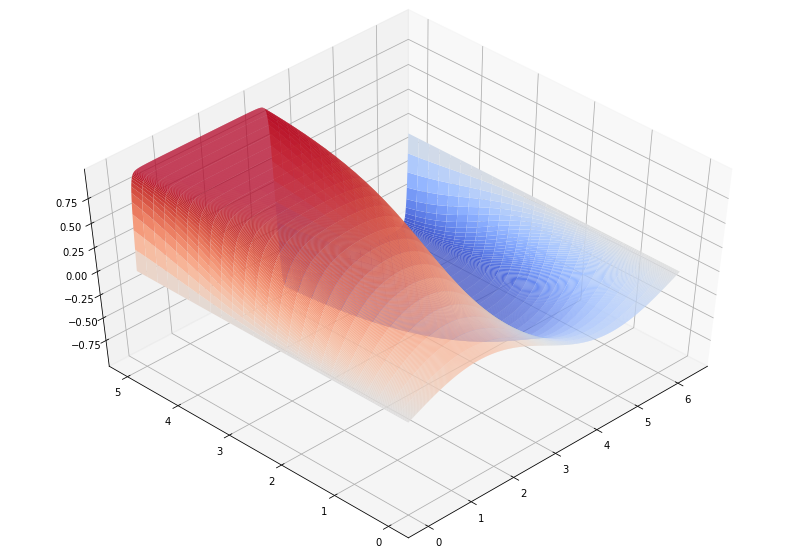

In [34]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(x_grid, t_grid, data, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.view_init(elev=50, azim=-135)
plt.show()